In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bot-iot/bot_iot.csv


In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

In [11]:
dataset_path = "/kaggle/input/bot-iot/bot_iot.csv"
df = pd.read_csv(dataset_path)

In [12]:
# Initial data exploration
print(df.info())
print(df.head())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 733705 entries, 0 to 733704
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   pkSeqID            733705 non-null  int64  
 1   proto              733705 non-null  object 
 2   saddr              733705 non-null  object 
 3   sport              733705 non-null  object 
 4   daddr              733705 non-null  object 
 5   dport              733705 non-null  object 
 6   seq                733705 non-null  int64  
 7   stddev             733705 non-null  float64
 8   N_IN_Conn_P_SrcIP  733705 non-null  int64  
 9   min                733705 non-null  float64
 10  state_number       733705 non-null  int64  
 11  mean               733705 non-null  float64
 12  N_IN_Conn_P_DstIP  733705 non-null  int64  
 13  drate              733705 non-null  float64
 14  srate              733705 non-null  float64
 15  max                733705 non-null  float64
 16  at

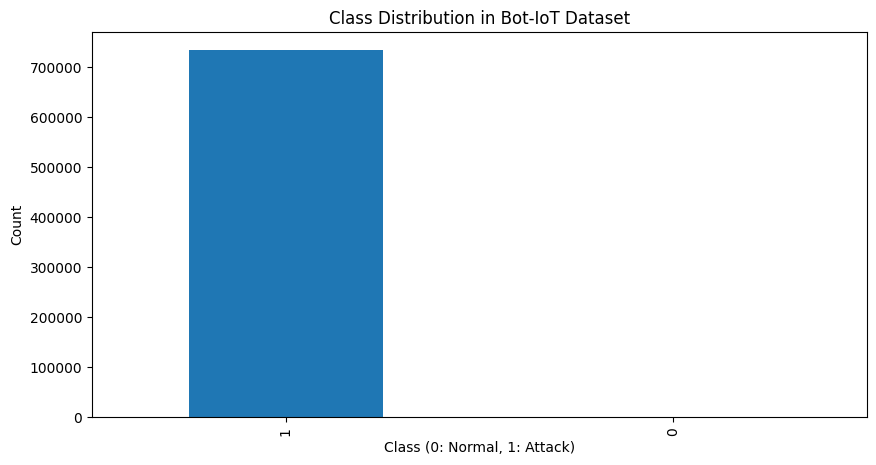

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
df['attack'].value_counts().plot(kind='bar')
plt.title('Class Distribution in Bot-IoT Dataset')
plt.xlabel('Class (0: Normal, 1: Attack)')
plt.ylabel('Count')
plt.show()

Text(0.5, 1.0, 'Attack Subcategory Distribution')

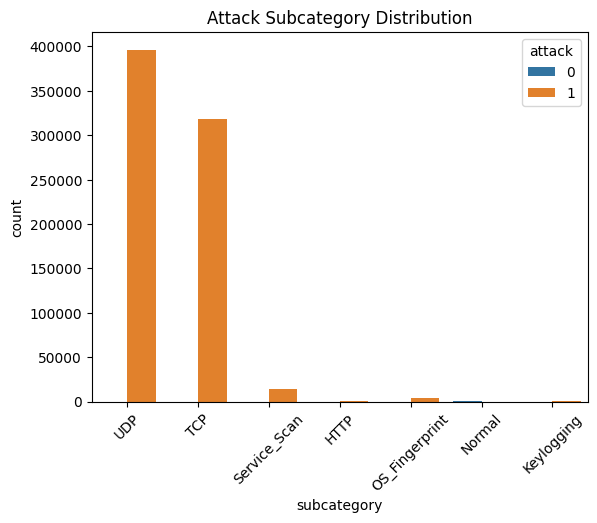

In [14]:
import seaborn as sns
sns.countplot(x='subcategory', data=df, hue='attack')
plt.xticks(rotation=45)
plt.title('Attack Subcategory Distribution')

In [15]:
# Drop pkSeqID as it's just an identifier
df = df.drop('pkSeqID', axis=1)

In [16]:
# Identify numeric and categorical columns
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

In [17]:
# Remove target variables from features
target_cols = ['attack', 'category', 'subcategory']
for col in target_cols:
    if col in numeric_cols:
        numeric_cols.remove(col)
    if col in categorical_cols:
        categorical_cols.remove(col)

In [18]:
# Separate features and target
X = df.drop(target_cols, axis=1)
y = df['attack']  # Binary classification: attack (1) or not (0)

In [19]:
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


In [20]:
# Create preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [24]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

In [25]:
# Preprocess the data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

In [26]:
X_train_preprocessed

<513593x69192 sparse matrix of type '<class 'numpy.float64'>'
	with 7703895 stored elements in Compressed Sparse Row format>

In [28]:
# Baseline Random Forest
rf = RandomForestClassifier(random_state=42)

Baseline Random Forest Performance:
Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.91      0.95        32
           1       1.00      1.00      1.00    220080

    accuracy                           1.00    220112
   macro avg       1.00      0.95      0.98    220112
weighted avg       1.00      1.00      1.00    220112


Confusion Matrix:
[[    29      3]
 [     0 220080]]

Top 10 Important Features:
                   Feature  Importance
68217             dport_53    0.089106
6        N_IN_Conn_P_DstIP    0.065564
65568  daddr_192.168.217.2    0.045584
5                     mean    0.044927
3                      min    0.038600
9                      max    0.037587
4             state_number    0.037251
8                    srate    0.035665
68226           dport_5353    0.032888
0                      seq    0.031614


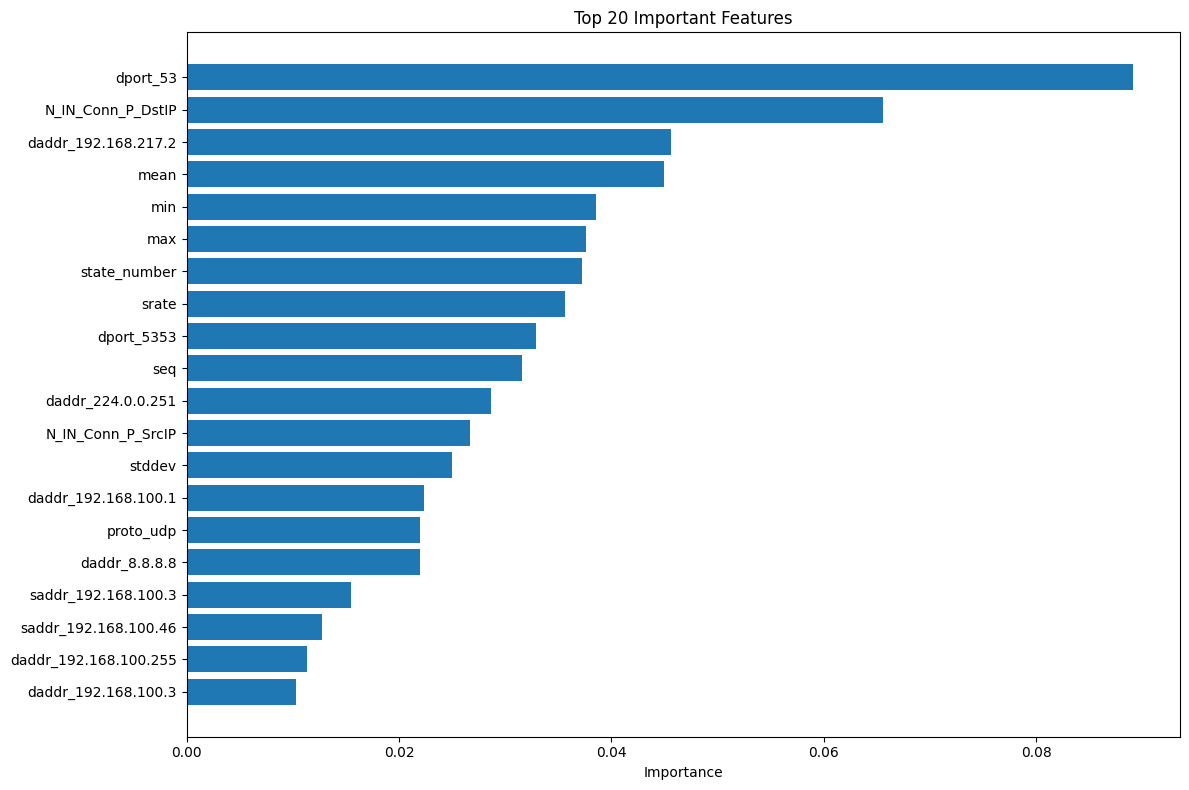

In [29]:
# Baseline Random Forest Model with Proper Preprocessing

# Create the preprocessing and modeling pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),  # Our preprocessing steps
    ('classifier', RandomForestClassifier(random_state=42))
])

# Train the model
pipeline.fit(X_train, y_train)

# Evaluate on test set
y_pred = pipeline.predict(X_test)

# Performance metrics
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

print("Baseline Random Forest Performance:")
print("==================================")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Feature importances (need to get them from the classifier step)
rf_model = pipeline.named_steps['classifier']
feature_names = (numeric_cols + 
                 list(pipeline.named_steps['preprocessor']
                     .named_transformers_['cat']
                     .named_steps['onehot']
                     .get_feature_names_out(categorical_cols)))

feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 Important Features:")
print(feature_importances.head(10))

# Plot feature importances
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
plt.barh(feature_importances['Feature'][:20], 
         feature_importances['Importance'][:20])
plt.xlabel('Importance')
plt.title('Top 20 Important Features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Starting Grid Search Hyperparameter Tuning...
Fitting 3 folds for each of 216 candidates, totalling 648 fits
Grid Search completed successfully!

Best Parameters Found:
classifier__max_depth: None
classifier__max_features: sqrt
classifier__min_samples_leaf: 1
classifier__min_samples_split: 2
classifier__n_estimators: 200

Optimized Model Performance:
Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.84      0.92        32
           1       1.00      1.00      1.00    220080

    accuracy                           1.00    220112
   macro avg       1.00      0.92      0.96    220112
weighted avg       1.00      1.00      1.00    220112


Confusion Matrix:
[[    27      5]
 [     0 220080]]

Top 10 Most Important Features:
                   Feature  Importance
68217             dport_53    0.107518
6        N_IN_Conn_P_DstIP    0.060805
5                     mean    0.042857
65568  daddr_192.168.217.2    0.0406

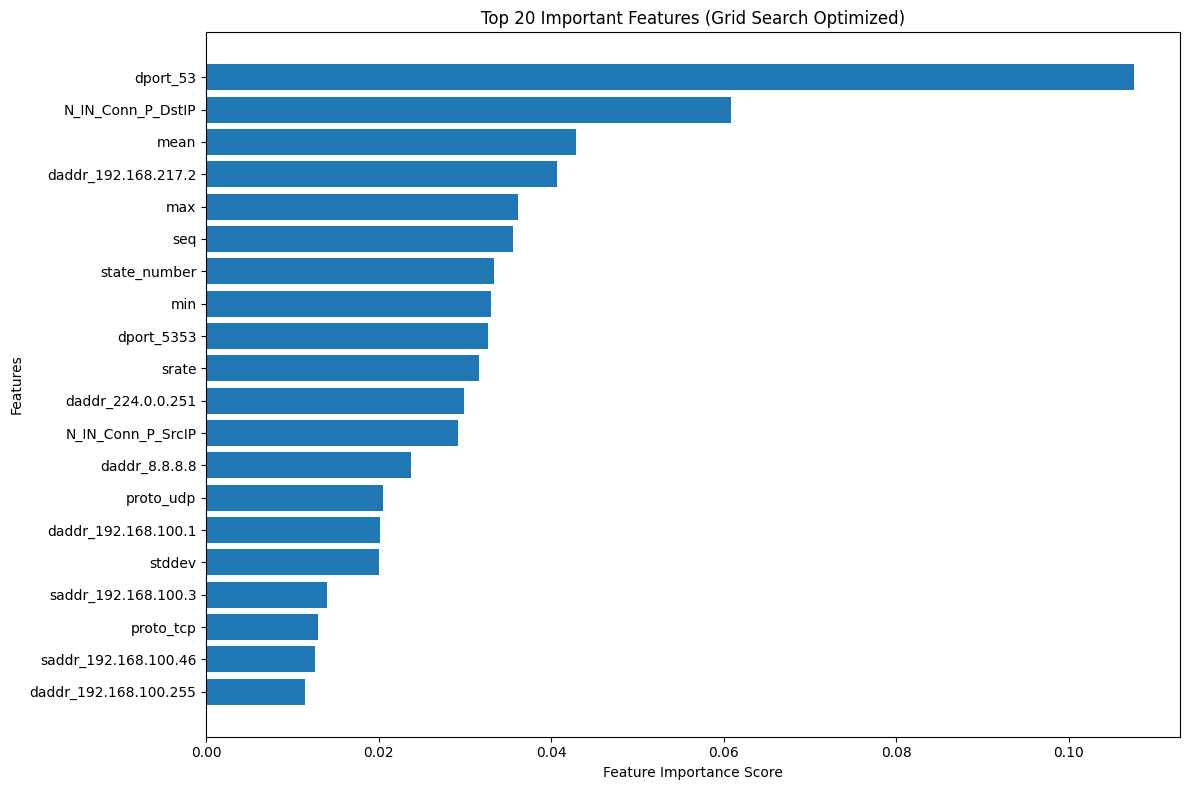

['best_random_forest_gridsearch.pkl']

In [30]:
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

# Define the parameter grid for Random Forest
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['sqrt', 'log2']
}

# Create GridSearchCV object with our pipeline
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    verbose=2,
    scoring='accuracy'
)

# Execute the grid search
print("Starting Grid Search Hyperparameter Tuning...")
grid_search.fit(X_train, y_train)
print("Grid Search completed successfully!")

# Get the best model and parameters
best_rf_grid = grid_search.best_estimator_
best_params = grid_search.best_params_

print("\nBest Parameters Found:")
for param, value in best_params.items():
    print(f"{param}: {value}")

# Evaluate on test set
y_pred_grid = best_rf_grid.predict(X_test)

print("\nOptimized Model Performance:")
print("===========================")
print(f"Accuracy: {accuracy_score(y_test, y_pred_grid):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_grid))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_grid))

# Feature Importance Analysis
feature_importances = best_rf_grid.named_steps['classifier'].feature_importances_
features = (numeric_cols + 
           list(pipeline.named_steps['preprocessor']
               .named_transformers_['cat']
               .named_steps['onehot']
               .get_feature_names_out(categorical_cols)))

importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values('Importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(importance_df.head(10))

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'].head(20), importance_df['Importance'].head(20))
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Top 20 Important Features (Grid Search Optimized)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Save the best model (optional)
import joblib
joblib.dump(best_rf_grid, 'best_random_forest_gridsearch.pkl')

Starting Bayesian Optimization Hyperparameter Tuning...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


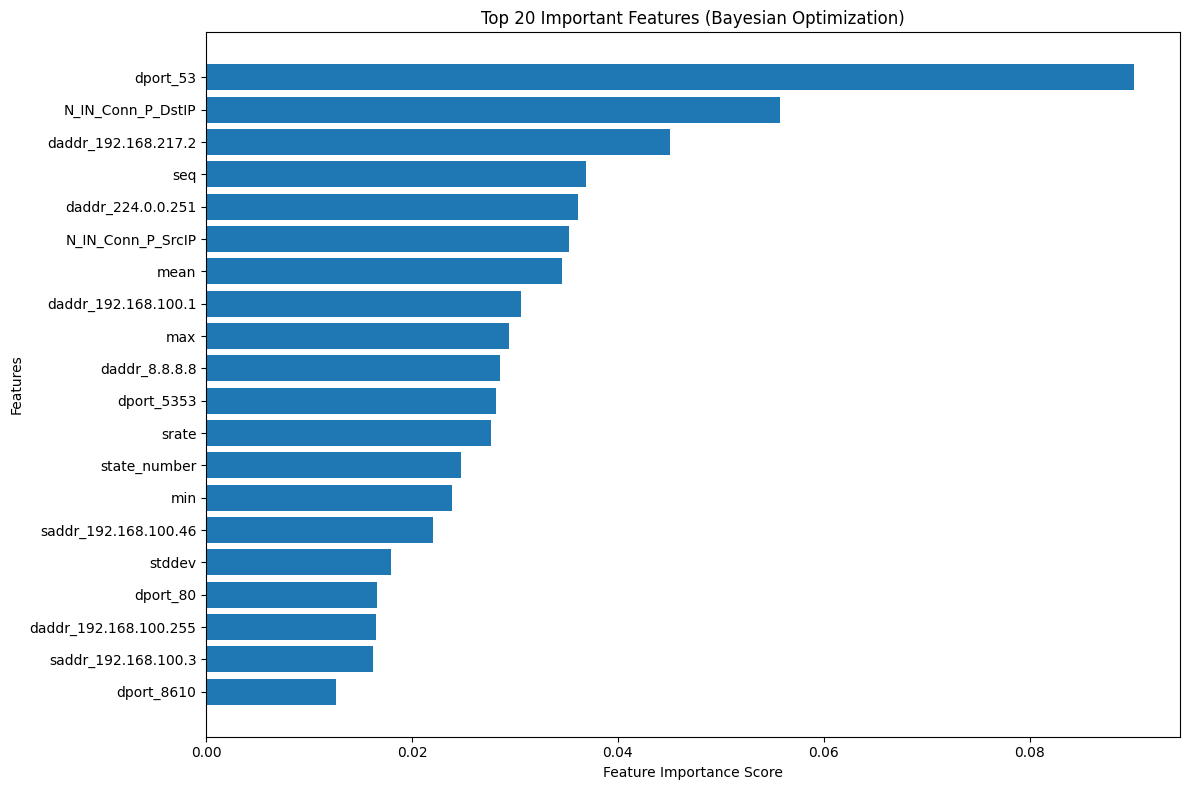

<Figure size 800x600 with 0 Axes>

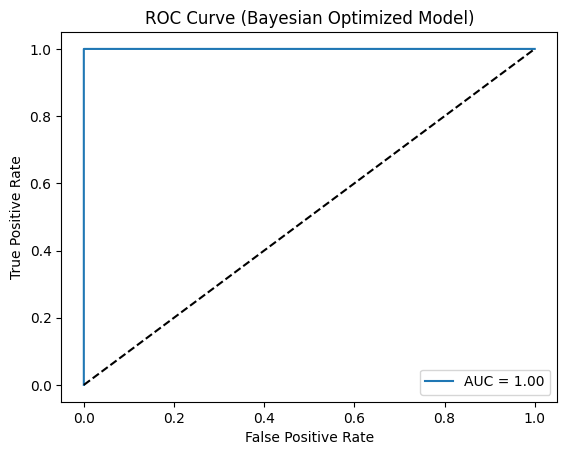


AUC-ROC Score: 1.0000


['best_random_forest_bayesian.pkl']

In [31]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

# Define the search space for Bayesian Optimization
bayes_space = {
    'classifier__n_estimators': Integer(100, 500),
    'classifier__max_depth': Integer(5, 50),
    'classifier__min_samples_split': Integer(2, 20),
    'classifier__min_samples_leaf': Integer(1, 10),
    'classifier__max_features': Categorical(['sqrt', 'log2']),
    'classifier__bootstrap': Categorical([True, False])
}

# Create BayesSearchCV object
bayes_search = BayesSearchCV(
    estimator=pipeline,
    search_spaces=bayes_space,
    n_iter=50,  # Number of iterations
    cv=5,
    n_jobs=-1,
    verbose=1,
    random_state=42,
    scoring='accuracy'
)

# Execute Bayesian Optimization
print("Starting Bayesian Optimization Hyperparameter Tuning...")
bayes_search.fit(X_train, y_train)
print("Bayesian Optimization completed successfully!")

# Get the best model and parameters
best_rf_bayes = bayes_search.best_estimator_
best_params_bayes = bayes_search.best_params_

print("\nBest Parameters Found:")
for param, value in best_params_bayes.items():
    print(f"{param}: {value}")

# Evaluate on test set
y_pred_bayes = best_rf_bayes.predict(X_test)

print("\nBayesian Optimized Model Performance:")
print("====================================")
print(f"Accuracy: {accuracy_score(y_test, y_pred_bayes):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_bayes))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_bayes))

# Feature Importance Analysis
feature_importances_bayes = best_rf_bayes.named_steps['classifier'].feature_importances_
importance_df_bayes = pd.DataFrame({'Feature': features, 'Importance': feature_importances_bayes})
importance_df_bayes = importance_df_bayes.sort_values('Importance', ascending=False)

print("\nTop 10 Most Important Features (Bayesian Optimization):")
print(importance_df_bayes.head(10))

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.barh(importance_df_bayes['Feature'].head(20), importance_df_bayes['Importance'].head(20))
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Top 20 Important Features (Bayesian Optimization)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# ROC Curve Analysis
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

y_probs = best_rf_bayes.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()
plt.title('ROC Curve (Bayesian Optimized Model)')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.show()

print(f"\nAUC-ROC Score: {roc_auc:.4f}")

# Save the best model (optional)
joblib.dump(best_rf_bayes, 'best_random_forest_bayesian.pkl')

In [54]:
df.shape

(733705, 18)